In [40]:
import numpy as np
import tensorflow as tf
import soundfile as sf
import resampy
import librosa
import tensorflow.keras.backend as K
import spec_augment
import keras.backend as K
import yamnet as yamnet_model
import params as yamnet_params
import os
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import yamnet as yamnet_model
import params as yamnet_params
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib.pyplot as plt
from audiomentations import Compose, AddBackgroundNoise, TimeStretch, PitchShift, Shift, AddGaussianNoise
import random

In [41]:
def load_finetunable_yamnet():
    params = yamnet_params.Params()
    model = yamnet_model.yamnet_frames_model(params)
    model.load_weights('yamnet.h5')  # download: https://storage.googleapis.com/audioset/yamnet.h5

    for layer in model.layers[-20:]:
        layer.trainable = True
    return model


In [42]:
# def augment_audio(audio, sr):
#     if np.random.rand() < 0.5:
#         audio = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=np.random.randint(-2, 3))
#     if np.random.rand() < 0.5:
#         audio = librosa.effects.time_stretch(y=audio, rate=np.random.uniform(0.8, 1.2))
#     if np.random.rand() < 0.5:
#         noise = 0.005 * np.random.randn(len(audio))
#         audio = audio + noise
#     return np.clip(audio, -1.0, 1.0)

from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain

augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_shift=-0.5, max_shift=0.5, p=0.5),
    Gain(min_gain_db=-6, max_gain_db=6, p=0.5)
])

# from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain, ClippingDistortion, PolarityInversion

# augment = Compose([
#     AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
#     TimeStretch(min_rate=0.85, max_rate=1.15, p=0.5),
#     PitchShift(min_semitones=-3, max_semitones=3, p=0.5),
#     Shift(min_shift=-0.2, max_shift=0.2, p=0.5),
#     Gain(min_gain_db=-6, max_gain_db=6, p=0.5),
#     ClippingDistortion(min_percentile_threshold=0, max_percentile_threshold=30, p=0.4),  # Random distortion
#     PolarityInversion(p=0.3),  # Flip signal polarity
# ])
# Function to apply SpecAugment
# def apply_specaugment(mel_spec):
#     mel_spec = np.expand_dims(mel_spec, axis=0)  # Add batch dimension
#     mel_spec = tf.convert_to_tensor(mel_spec, dtype=tf.float32)

#     # Apply SpecAugment
#     augmented_mel_spec = spec_augment.augment(mel_spec)

#     return augmented_mel_spec.numpy().squeeze()  # Remove batch dimension

def apply_specaugment(mel_spec, time_mask_param=10, freq_mask_param=8):
    mel = mel_spec.copy()
    num_mel_channels, num_time_steps = mel.shape

    # Time mask
    t = np.random.randint(0, time_mask_param)
    t0 = np.random.randint(0, max(1, num_time_steps - t))
    mel[:, t0:t0 + t] = 0

    # Frequency mask
    f = np.random.randint(0, freq_mask_param)
    f0 = np.random.randint(0, max(1, num_mel_channels - f))
    mel[f0:f0 + f, :] = 0

    return mel


def augment_audio(audio, sr):
    audio = augment(samples=audio, sample_rate=sr)
    return np.clip(audio, -1.0, 1.0)


In [4]:
# def extract_features_finetuned(yamnet, audio_path, sample_rate=16000):
#     # try:
#         y, sr = librosa.load(audio_path, sr=sample_rate)
#         y = augment_audio(y, sr)  # <—— AUGMENTED HERE

#         waveform = tf.convert_to_tensor(y, dtype=tf.float32)
#         waveform = tf.reshape(waveform, [-1])

#         _, embeddings, _ = yamnet(waveform)
#         avg_embedding = tf.reduce_mean(embeddings, axis=0).numpy()  # (1024,)

#         mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
#         mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
#         mel_spec_flat = np.mean(mel_spec_db, axis=1)  # (40,)

#         return np.concatenate([avg_embedding, mel_spec_flat])  # (1064,)
def extract_features_finetuned(yamnet, audio_path, sample_rate=16000, use_specaugment=True):
    y, sr = librosa.load(audio_path, sr=sample_rate)
    y = augment_audio(y, sr)  # Apply other augmentations like time stretch, pitch shift

    waveform = tf.convert_to_tensor(y, dtype=tf.float32)
    waveform = tf.reshape(waveform, [-1])

    # Get YAMNet embeddings
    _, embeddings, _ = yamnet(waveform)
    avg_embedding = tf.reduce_mean(embeddings, axis=0).numpy()  # (1024,)

    # Create Mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Apply SpecAugment during training (not for validation/test)
    if use_specaugment:
        mel_spec_db = apply_specaugment(mel_spec_db)

    mel_spec_flat = np.mean(mel_spec_db, axis=1)  # (40,)
    
    return np.concatenate([avg_embedding, mel_spec_flat])  # Concatenate YAMNet embeddings with Mel-spectrogram features


In [5]:
def extract_features_from_folder(base_path):
    X, y = [], []
    yamnet = load_finetunable_yamnet()

    label_encoder = LabelEncoder()
    all_labels = sorted(os.listdir(base_path))  # e.g., ['child_danger', 'normal', 'woman_danger']
    label_encoder.fit(all_labels)

    for label in tqdm(all_labels, desc="Processing folders"):
        folder_path = os.path.join(base_path, label)
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(folder_path, file)
                features = extract_features_finetuned(yamnet, file_path)
                # features = extract_features_finetuned(yamnet, file_path, augment_audio=True)
                if features is not None:
                    X.append(features)
                    y.append(label)

    X = np.array(X)
    y = label_encoder.transform(y)
    return X, y, label_encoder


In [ ]:
X, y, label_encoder = extract_features_from_folder(r'C:\Users\Vishal Kumar Patel\Desktop\Yamnetmodelproject\data\train')
print("Feature shape:", X.shape)
print("Label shape:", y.shape)
print("Classes:", label_encoder.classes_) 
np.save("X_embeddings_augmented.npy", X)
np.save("y_labels_augmented.npy", y)

Processing folders:   0%|                                                                        | 0/2 [00:00<?, ?it/s]

In [45]:

# Load embeddings and labels from saved files
X = np.load("X_embeddings_augmented.npy")  # shape: (n_samples, 1024)
y = np.load("y_labels_augmented.npy")      # shape: (n_samples,)


In [46]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, BatchNormalization, Activation, Multiply, Flatten, Lambda
import tensorflow.keras.backend as K

# ----------------- Data Preprocessing -----------------

# One-hot encode labels
num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)

# Reshape for BiLSTM [samples, time_steps=1, features]
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=np.argmax(y_cat, axis=1))
class_weights_dict = dict(enumerate(class_weights))

# ----------------- Attention Block -----------------
def attention_block(inputs):
    attention_weights = Dense(1, activation='tanh')(inputs)
    attention_weights = Activation('softmax')(attention_weights)
    weighted_input = Multiply()([inputs, attention_weights])
    context_vector = Lambda(lambda x: K.sum(x, axis=1))(weighted_input)
    # context_vector = Lambda(lambda x: K.sum(x, axis=1), output_shape=(inputs.shape[1],))(weighted_input)  
    return context_vector

# ----------------- Model Definition -----------------
input_layer = Input(shape=(1, X.shape[1]))  # Define input shape
x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_block(x)
x = Flatten()(x) 
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ----------------- Summary -----------------
model.summary()



# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, Layer, Flatten, Multiply, Permute
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint



# # One-hot encode labels
# num_classes = len(np.unique(y))
# y_cat = to_categorical(y, num_classes)

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)

# # Reshape for BiLSTM [samples, time_steps=1, features]
# X_train = np.expand_dims(X_train, axis=1)
# X_test = np.expand_dims(X_test, axis=1)

# # Compute class weights
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=np.argmax(y_cat, axis=1))
# class_weights_dict = dict(enumerate(class_weights))

# # ----------------- Attention Layer -----------------
# class Attention(Layer):
#     def __init__(self, **kwargs):
#         super(Attention, self).__init__(**kwargs)

#     def build(self, input_shape):
#         self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
#                                  initializer='normal', trainable=True)
#         self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
#                                  initializer='zeros', trainable=True)
#         super(Attention, self).build(input_shape)

#     def call(self, x):
#         e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
#         a = tf.keras.backend.softmax(e, axis=1)
#         output = x * a
#         return tf.keras.backend.sum(output, axis=1)

# # ----------------- Model Architecture -----------------
# input_layer = Input(shape=(1, 1064))  # Input shape
# x = tf.keras.layers.Reshape((1064, 1))(input_layer)  # Reshape for LSTM

# x = Bidirectional(LSTM(128, return_sequences=True))(x)
# x = Dropout(0.5)(x)
# x = Attention()(x)

# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)
# output_layer = Dense(1, activation='sigmoid')(x)

# model = Model(inputs=input_layer, outputs=output_layer)
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()



Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)   │ (None, 1, 1064)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_20              │ (None, 1, 256)            │       1,221,632 │ input_layer_20[0][0]       │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_39        │ (None, 1, 256)            │           1,024 │ bidirectional_20[0][0]     │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_39 (Dropout)          │ (None, 1, 256)            │               0 │ batch_normalization_39[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_58 (Dense)              │ (None, 1, 1)              │             257 │ dropout_39[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_20 (Activation)    │ (None, 1, 1)              │               0 │ dense_58[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply_20 (Multiply)        │ (None, 1, 256)            │               0 │ dropout_39[0][0],          │
│                               │                           │                 │ activation_20[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_2 (Lambda)             │ (None, 256)               │               0 │ multiply_20[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_19 (Flatten)          │ (None, 256)               │               0 │ lambda_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_59 (Dense)              │ (None, 128)               │          32,896 │ flatten_19[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_40        │ (None, 128)               │             512 │ dense_59[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_40 (Dropout)          │ (None, 128)               │               0 │ batch_normalization_40[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_60 (Dense)              │ (None, 2)                 │             258 │ dropout_40[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,256,579 (4.79 MB)

 Trainable params: 1,255,811 (4.79 MB)

 Non-trainable params: 768 (3.00 KB)

In [47]:
# from tensorflow.keras.callbacks import EarlyStopping

# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# history = model.fit(
#     X_train, y_train,
#     validation_split=0.2,
#     epochs=50,
#     batch_size=64,
#     class_weight=class_weights_dict,
#     callbacks=[early_stop],
#     verbose=1
# )


# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# model.fit(
#     X_train, y_train,
#     validation_split=0.2,
#     epochs=50,
#     batch_size=64,
#     class_weight=class_weights_dict,
#     callbacks=[reduce_lr, early_stop],
#     verbose=1
# )

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# from tensorflow.keras.utils import to_categorical

# ----------------- Callbacks -----------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# ----------------- Train Model -----------------
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint]
)







Epoch 1/50


C:\Users\Vishal Kumar Patel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8081 - loss: 0.4968
Epoch 1: val_loss improved from inf to 0.30803, saving model to best_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.8085 - loss: 0.4959 - val_accuracy: 0.8891 - val_loss: 0.3080 - learning_rate: 0.0010
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8885 - loss: 0.2856
Epoch 2: val_loss improved from 0.30803 to 0.28003, saving model to best_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8885 - loss: 0.2855 - val_accuracy: 0.8830 - val_loss: 0.2800 - learning_rate: 0.0010
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9051 - loss: 0.2503
Epoch 3: val_loss improved from 0.28003 to 0.21336, saving model to best_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9051 - loss: 0.2502 - val_accuracy: 0.9185 - val_loss: 0.2134 - learning_rate: 0.0010
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9101 - loss: 0.2307
Epoch 4: val_loss improved from 0.21336 to 0.20268, saving model to best_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9101 - loss: 0.2307 - val_accuracy: 0.9224 - val_loss: 0.2027 - learning_rate: 0.0010
Epoch 5/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9126 - loss: 0.2272
Epoch 5: val_loss did not improve from 0.20268
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9126 - loss: 0.2271 - val_accuracy: 0.9041 - val_loss: 0.2355 - learning_rate: 0.0010
Epoch 6/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9178 - loss: 0.2040
Epoch 6: val_loss did not improve from 0.20268
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9178 - loss: 0.2040 - val_accuracy: 0.8570 - val_loss: 0.3572 - learning_rate: 0.0010
Epoch 7/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9234 - loss: 0.2029
Epoch 7: val_loss did not improve from 0.20268
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9234 - loss: 0.2029 - val_accuracy: 0.9108 - val_loss: 0.2408 - learning_rate: 0.0010
Epoch 8/50
226/226 ━━━━━━━━━━━

226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9323 - loss: 0.1745 - val_accuracy: 0.9274 - val_loss: 0.1850 - learning_rate: 5.0000e-04
Epoch 11/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9354 - loss: 0.1671
Epoch 11: val_loss did not improve from 0.18501
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9354 - loss: 0.1671 - val_accuracy: 0.9224 - val_loss: 0.2092 - learning_rate: 5.0000e-04
Epoch 12/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9282 - loss: 0.1746
Epoch 12: val_loss did not improve from 0.18501
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9282 - loss: 0.1746 - val_accuracy: 0.9246 - val_loss: 0.1851 - learning_rate: 5.0000e-04
Epoch 13/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9372 - loss: 0.1625
Epoch 13: val_loss did not improve from 0.18501
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9372 - loss: 0.1625 - val_accuracy: 0.9257 - val_loss: 0.1853 - learning_rate: 5.0000e-04
Epoch 14

226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9410 - loss: 0.1512 - val_accuracy: 0.9268 - val_loss: 0.1790 - learning_rate: 2.5000e-04
Epoch 15/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9453 - loss: 0.1416
Epoch 15: val_loss did not improve from 0.17899
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9453 - loss: 0.1416 - val_accuracy: 0.9235 - val_loss: 0.1962 - learning_rate: 2.5000e-04
Epoch 16/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9452 - loss: 0.1395
Epoch 16: val_loss did not improve from 0.17899
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9452 - loss: 0.1395 - val_accuracy: 0.9252 - val_loss: 0.1968 - learning_rate: 2.5000e-04
Epoch 17/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9442 - loss: 0.1400
Epoch 17: val_loss did not improve from 0.17899
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9442 - loss: 0.1399 - val_accuracy: 0.9235 - val_loss: 0.1911 - learning_rate: 2.5000e-04
Epoch 18

226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9517 - loss: 0.1328 - val_accuracy: 0.9290 - val_loss: 0.1763 - learning_rate: 1.2500e-04
Epoch 20/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9487 - loss: 0.1318
Epoch 20: val_loss improved from 0.17630 to 0.17607, saving model to best_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9487 - loss: 0.1318 - val_accuracy: 0.9296 - val_loss: 0.1761 - learning_rate: 1.2500e-04
Epoch 21/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9468 - loss: 0.1333
Epoch 21: val_loss did not improve from 0.17607
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9469 - loss: 0.1333 - val_accuracy: 0.9302 - val_loss: 0.1838 - learning_rate: 1.2500e-04
Epoch 22/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9499 - loss: 0.1272
Epoch 22: val_loss did not improve from 0.17607
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9499 - loss: 0.1272 - val_accuracy: 0.9307 - val_loss: 0.1765 - learning_rate: 1.2500e-04
Epoch 23/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9531 - loss: 0.1258
Epoch 23: val_loss did not improve from 0.17607
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9531 - loss: 0.1258 - val_accuracy: 0.9257 - val_loss: 0.1870 - learning_rate: 1.2500e-04
Epoch 24

226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9523 - loss: 0.1234 - val_accuracy: 0.9302 - val_loss: 0.1754 - learning_rate: 6.2500e-05
Epoch 25/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9498 - loss: 0.1209
Epoch 25: val_loss improved from 0.17539 to 0.17489, saving model to best_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9498 - loss: 0.1209 - val_accuracy: 0.9296 - val_loss: 0.1749 - learning_rate: 6.2500e-05
Epoch 26/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9535 - loss: 0.1209
Epoch 26: val_loss did not improve from 0.17489
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9535 - loss: 0.1209 - val_accuracy: 0.9263 - val_loss: 0.1750 - learning_rate: 6.2500e-05
Epoch 27/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9553 - loss: 0.1129
Epoch 27: val_loss did not improve from 0.17489
226/226 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9553 - loss: 0.1128 - val_accuracy: 0.9268 - val_loss: 0.1765 - learning_rate: 6.2500e-05
Epoch 28/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9532 - loss: 0.1154
Epoch 28: val_loss did not improve from 0.17489
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9532 - loss: 0.1154 - val_accuracy: 0.9302 - val_loss: 0.1789 - learning_rate: 6.2500e-05
Epoch 29

226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9573 - loss: 0.1153 - val_accuracy: 0.9329 - val_loss: 0.1745 - learning_rate: 3.1250e-05
Epoch 31/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9568 - loss: 0.1084
Epoch 31: val_loss did not improve from 0.17451
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9568 - loss: 0.1084 - val_accuracy: 0.9290 - val_loss: 0.1763 - learning_rate: 3.1250e-05
Epoch 32/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9563 - loss: 0.1082
Epoch 32: val_loss improved from 0.17451 to 0.17401, saving model to best_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9563 - loss: 0.1082 - val_accuracy: 0.9313 - val_loss: 0.1740 - learning_rate: 3.1250e-05
Epoch 33/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9583 - loss: 0.1092
Epoch 33: val_loss did not improve from 0.17401
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9583 - loss: 0.1092 - val_accuracy: 0.9324 - val_loss: 0.1761 - learning_rate: 3.1250e-05
Epoch 34/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9592 - loss: 0.1087
Epoch 34: val_loss did not improve from 0.17401
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9592 - loss: 0.1087 - val_accuracy: 0.9302 - val_loss: 0.1756 - learning_rate: 3.1250e-05
Epoch 35/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9618 - loss: 0.1029
Epoch 35: val_loss did not improve from 0.17401
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9618 - loss: 0.1029 - val_accuracy: 0.9313 - val_loss: 0.1761 - learning_rate: 3.1250e-05
Epoch 36

In [48]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9370 - loss: 0.1684
✅ Test Accuracy: 93.13%


  1/226 ━━━━━━━━━━━━━━━━━━━━ 1:21 361ms/step

C:\Users\Vishal Kumar Patel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


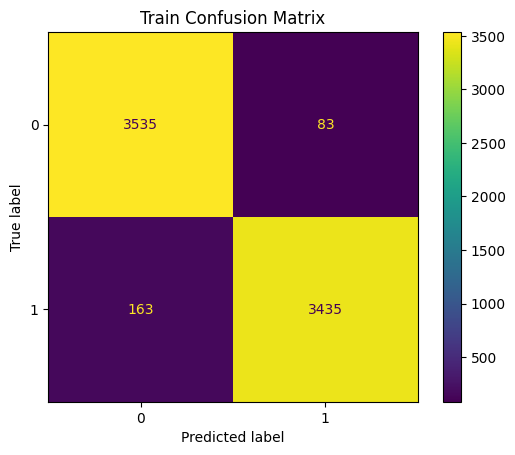

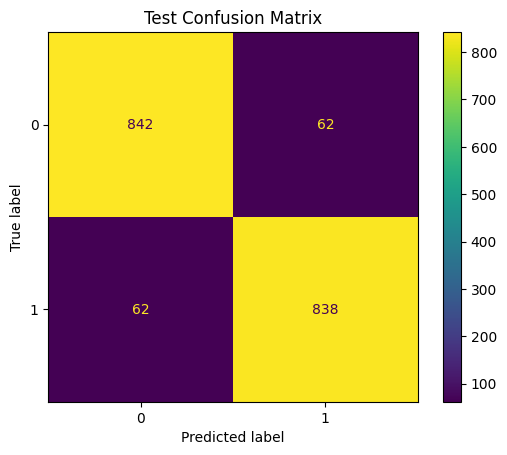

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       904
           1       0.93      0.93      0.93       900

    accuracy                           0.93      1804
   macro avg       0.93      0.93      0.93      1804
weighted avg       0.93      0.93      0.93      1804



In [49]:
# predicted_test = model.predict(X_test)
# predicted_train = model.predict(X_train)
# predicted_class = []
# for i in range(len(predicted_train)):
#   predicted_class.append(np.argmax(predicted_train[i]))
# predicted_class_index = []
# for i in range(len(predicted_test)):
#   predicted_class_index.append(np.argmax(predicted_test[i]))
# rounded_test = np.argmax(y_test,axis=1)
# rounded_train = np.argmax(y_train,axis=1)


# confusion_matrix = metrics.confusion_matrix(rounded_train, predicted_class)

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

# cm_display.plot()
# plt.show()


# confusion_matrix = metrics.confusion_matrix(rounded_test, predicted_class_index)

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

# cm_display.plot()
# plt.show()


# print(classification_report(rounded_test, predicted_class_index))


import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict on train and test sets
predicted_train = model.predict(X_train)
predicted_test = model.predict(X_test)

# Convert predictions to class indices
predicted_train_classes = np.argmax(predicted_train, axis=1)
predicted_test_classes = np.argmax(predicted_test, axis=1)

# Convert one-hot encoded true labels to class indices
true_train_classes = np.argmax(y_train, axis=1)
true_test_classes = np.argmax(y_test, axis=1)

# ----------------- Train Confusion Matrix -----------------
cm_train = confusion_matrix(true_train_classes, predicted_train_classes)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.title("Train Confusion Matrix")
plt.show()

# ----------------- Test Confusion Matrix -----------------
cm_test = confusion_matrix(true_test_classes, predicted_test_classes)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()
plt.title("Test Confusion Matrix")
plt.show()

# ----------------- Classification Report -----------------
print("Classification Report (Test Data):")
print(classification_report(true_test_classes, predicted_test_classes))





In [50]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=['woman_danger', 'normal']))


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

woman_danger       0.93      0.93      0.93       904
      normal       0.93      0.93      0.93       900

    accuracy                           0.93      1804
   macro avg       0.93      0.93      0.93      1804
weighted avg       0.93      0.93      0.93      1804



In [53]:
model.save('final_best.h5')



In [73]:
# import numpy as np
# import tensorflow as tf
# import librosa
# import random
# import tensorflow_hub as hub
# from tensorflow.keras.models import load_model, Model
# from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, BatchNormalization, Activation, Multiply, Flatten, Lambda
# import tensorflow.keras.backend as K

# # ----------------- Set seeds for reproducibility -----------------
# np.random.seed(42)
# tf.random.set_seed(42)
# random.seed(42)

# # ----------------- Custom Layers & Functions -----------------
# class SumLayer(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(SumLayer, self).__init__(**kwargs)
    
#     def call(self, inputs):
#         return K.sum(inputs, axis=1)
    
#     def compute_output_shape(self, input_shape):
#         return (input_shape[0], input_shape[2])

# def normalize_input(x):
#     return (x / tf.reduce_max(x)) - tf.reduce_mean(x)

# def attention_mechanism(inputs):
#     attention_weights = Dense(1, activation='tanh')(inputs)
#     attention_weights = Activation('softmax')(attention_weights)
#     weighted_input = Multiply()([inputs, attention_weights])
#     return SumLayer()(weighted_input)

# # Define custom lambda layer with explicit output shape
# def sum_layer_wrapper(x):
#     return K.sum(x, axis=1)

# def sum_layer_shape(input_shape):
#     return (input_shape[0], input_shape[2])

# def extract_yamnet_embedding(audio_path):
#     yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')
#     waveform, sr = librosa.load(audio_path, sr=16000)
#     waveform = waveform[:sr * 10]  # Limit to 10 seconds
#     waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)
#     _, embeddings, _ = yamnet_model(waveform)
#     embedding_mean = tf.reduce_mean(embeddings, axis=0).numpy()
    
#     if embedding_mean.shape[0] < 1064:
#         embedding_mean = np.pad(embedding_mean, (0, 1064 - embedding_mean.shape[0]), mode='constant')
#     else:
#         embedding_mean = embedding_mean[:1064]
        
#     return embedding_mean

# def test_audio(file_path, model, classes):
#     yamnet_embedding = extract_yamnet_embedding(file_path)
#     input_data = np.expand_dims(np.expand_dims(yamnet_embedding, axis=0), axis=1)
    
#     try:
#         predictions = model.predict(input_data, verbose=0)
#     except Exception as e:
#         print(f"Error during prediction: {e}")
#         return None, None
    
#     class_probabilities = predictions[0]
#     predicted_class_index = np.argmax(class_probabilities)
    
#     return class_probabilities, predicted_class_index

# # ----------------- Main Execution -----------------
# if __name__ == "__main__":
#     classes = ['Normal', 'Danger']  # Class order

#     # Define custom objects you used
#     custom_objects = {
#         'normalize_input': normalize_input,
#         'SumLayer': SumLayer,
#         'attention_mechanism': attention_mechanism,
#         '<lambda>': Lambda(sum_layer_wrapper, output_shape=sum_layer_shape)
#     }
    
#     try:
#         # First try loading with compile=False
#         print("Attempting to load model...")
#         model = tf.keras.models.load_model('final_best.h5', 
#                                           custom_objects=custom_objects, 
#                                           compile=False)
#         print("✅ Model loaded successfully!")
#     except Exception as e:
#         print(f"Error loading model: {e}")
#         try:
#             # Try alternative loading method
#             print("Trying alternative loading method...")
#             model = tf.keras.models.load_model('final_best.h5', 
#                                               custom_objects=custom_objects, 
#                                               compile=False,
#                                               options=tf.saved_model.LoadOptions(experimental_io_device='/job:localhost'))
#             print("✅ Model loaded successfully with alternative method!")
#         except Exception as e2:
#             print(f"Both loading methods failed: {e2}")
#             print("Please make sure the model file exists and is not corrupted.")
#             exit(1)

#     model.trainable = False
#     # r'C:\Users\Vishal Kumar Patel\Desktop\Yamnetmodelproject\data\test\Women\121_11_patch.wav'
#     test_audio_file = r'C:\Users\Vishal Kumar Patel\Desktop\Yamnetmodelproject\data\test\Normal\119_6_right.wav'
#     print(f"\nClassifying audio file: {test_audio_file}")
    
#     class_probabilities, predicted_class_index = test_audio(test_audio_file, model, classes)
    
#     if class_probabilities is not None and predicted_class_index is not None:
#         for i, class_label in enumerate(classes):
#             print(f'Class: {class_label}, Probability: {class_probabilities[i]:.4f}')
#         print(f'\nThe audio is classified as: {classes[predicted_class_index]}')
#         print(f'Confidence: {class_probabilities[predicted_class_index]:.4f}')
        
#         # Final result
#         print("\nFINAL RESULT:")
#         print(f"Predicted: {classes[predicted_class_index]} with {class_probabilities[predicted_class_index]:.2%} confidence.")
#     else:
#         print("Prediction failed, no results to display.")



import numpy as np
import tensorflow as tf
import librosa
import random
import tensorflow_hub as hub
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, BatchNormalization, Activation, Multiply, Flatten, Lambda
import tensorflow.keras.backend as K

# ----------------- Set seeds for reproducibility -----------------
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# ----------------- Custom Layers & Functions -----------------
class SumLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SumLayer, self).__init__(**kwargs)
    
    def call(self, inputs):
        return K.sum(inputs, axis=1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[2])

def normalize_input(x):
    return (x / tf.reduce_max(x)) - tf.reduce_mean(x)

# Fixed attention block with proper Lambda layer output shape
def attention_block(inputs):
    attention_weights = Dense(1, activation='tanh')(inputs)
    attention_weights = Activation('softmax')(attention_weights)
    weighted_input = Multiply()([inputs, attention_weights])
    # Define proper output shape for Lambda layer
    context_vector = Lambda(lambda x: K.sum(x, axis=1), 
                           output_shape=lambda input_shape: (input_shape[0], input_shape[2]))(weighted_input)
    return context_vector

def extract_yamnet_embedding(audio_path):
    yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')
    waveform, sr = librosa.load(audio_path, sr=16000)
    waveform = waveform[:sr * 10]  # Limit to 10 seconds
    waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)
    _, embeddings, _ = yamnet_model(waveform)
    embedding_mean = tf.reduce_mean(embeddings, axis=0).numpy()
    
    if embedding_mean.shape[0] < 1064:
        embedding_mean = np.pad(embedding_mean, (0, 1064 - embedding_mean.shape[0]), mode='constant')
    else:
        embedding_mean = embedding_mean[:1064]
        
    return embedding_mean

def test_audio(file_path, model, classes):
    yamnet_embedding = extract_yamnet_embedding(file_path)
    input_data = np.expand_dims(np.expand_dims(yamnet_embedding, axis=0), axis=1)
    
    try:
        predictions = model.predict(input_data, verbose=0)
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None
    
    class_probabilities = predictions[0]
    predicted_class_index = np.argmax(class_probabilities)
    
    return class_probabilities, predicted_class_index

# Recreate the model with the same architecture as your original model
def create_model(input_shape=(1, 1064), num_classes=2):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Using the fixed attention block
    x = attention_block(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# ----------------- Main Execution -----------------
if __name__ == "__main__":
    classes = ['Normal', 'Danger']  # Class order

    # Create a new model with the same architecture
    print("Creating model with the same architecture...")
    model = create_model(input_shape=(1, 1064), num_classes=2)
    
    # Load weights from the saved model
    try:
        print("Loading weights from saved model...")
        model.load_weights('final_best.h5')
        print("✅ Model weights loaded successfully!")
    except Exception as e:
        print(f"Error loading weights: {e}")
        print("Using untrained model - results will be random.")
    
    model.trainable = False
    
    test_audio_file = r'C:\Users\Vishal Kumar Patel\Desktop\Yamnetmodelproject\data\test\Normal\112_3_right.wav'
    print(f"\nClassifying audio file: {test_audio_file}")
    
    class_probabilities, predicted_class_index = test_audio(test_audio_file, model, classes)
    
    if class_probabilities is not None and predicted_class_index is not None:
        for i, class_label in enumerate(classes):
            print(f'Class: {class_label}, Probability: {class_probabilities[i]:.4f}')
        print(f'\nThe audio is classified as: {classes[predicted_class_index]}')
        print(f'Confidence: {class_probabilities[predicted_class_index]:.4f}')
        
        # Final result
        print("\nFINAL RESULT:")
        print(f"Predicted: {classes[predicted_class_index]} with {class_probabilities[predicted_class_index]:.2%} confidence.")
    else:
        print("Prediction failed, no results to display.")

Creating model with the same architecture...
Loading weights from saved model...
✅ Model weights loaded successfully!

Classifying audio file: C:\Users\Vishal Kumar Patel\Desktop\Yamnetmodelproject\data\test\Normal\112_3_right.wav
Class: Normal, Probability: 0.0029
Class: Danger, Probability: 0.9971

The audio is classified as: Danger
Confidence: 0.9971

FINAL RESULT:
Predicted: Danger with 99.71% confidence.
